In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 15.9MB/s 
     |████████████████████████████████| 890kB 48.7MB/s 
     |████████████████████████████████| 1.1MB 46.3MB/s 
     |████████████████████████████████| 2.9MB 47.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=4bf755cb5bc9bd091c729f99188bcaa0b9661582299c71cc14bb9e5756209b4e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


[36674, 8255]

In [ ]:
df = pd.read_csv('breit29.csv',encoding='utf-8')

FileNotFoundError: ignored

In [ ]:
max_title = max([len(tokenizer.encode(row)) for row in df.title])

max_title

In [ ]:
import torch
torch.manual_seed(42)
from torch.utils.data import Dataset

class LoadBart(Dataset):

  def __init__(self, dataframe, tokenizer, gpt2_type="gpt2", max_length=max_title):

    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for text in dataframe:

      encodings_dict = tokenizer('<|startoftext|>'+ text + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=max_length, 
                                 padding="max_length") #pad to size of max title
      
      """
      Each iteration then appends either the encoded tensor to a list,
      or the attention mask for that encoding to a list. The attention mask is
      a binary list of 1's or 0's which determine whether the langauge model
      should take that token into consideration or not. 
      """
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
from torch.utils.data import random_split

dataset = LoadBart(df.title, tokenizer, max_length=max_title)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

In [ ]:
bs = 32

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = bs 
        )

NameError: ignored

In [ ]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
epochs = 4
warmup_steps = 1e2
sample_every = 100

In [ ]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 439. Loss:1.8870333433151245. Time:0:00:45
Example output:  bipartisanBiden Holds Climate Summit’s Accumulation Meeting To Win Re-election


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 439. Loss:1.4953500032424927. Time:0:01:32
Example output:  increasingAOC’s Keith Ellison: There Should Be No Sanctuary for Black Kids ‘That’ Is’ Left’ — ‘Worse’ That That We Get a Black President


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 439. Loss:1.5888175964355469. Time:0:02:18
Example output: dayNolte: Trump Supporter Cites Trump Supporters for Their ‘Fundraising of Socialism’


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 439. Loss:1.328472375869751. Time:0:03:04
Example output:  HangTrump Campaign Manager: ‘I’m Worried’ About Trump ‘Taking a ‘Threat’
Average Training Loss: 2.2713840064806927. Epoch time: 0:03:21
Validation loss: 1.3655166334035445. Validation Time: 0:00:07
Beginning epoch 2 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 439. Loss:1.3185899257659912. Time:0:00:46
Example output:  foodsJoe Biden Slams ‘Worse’ Ukraine Election: ‘I Don’t Have a Failing Presidency’


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 439. Loss:1.4003305435180664. Time:0:01:31
Example output:  trailBiden: No’s ‘No Chance of the Left’ Supporting Donald Trump Because of ‘His Corrupt Policies’


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 439. Loss:1.3166388273239136. Time:0:02:16
Example output: intendJoe Biden Mocks Obama for Praising Him: ‘The Left’ ‘Wields It Around Theirselves’


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 439. Loss:1.3266090154647827. Time:0:03:02
Example output:  surroundRonna McDaniel: Biden Will Give ‘Out the Vote’ if He Wins Reelection
Average Training Loss: 1.3057079156330342. Epoch time: 0:03:19
Validation loss: 1.3210969847075793. Validation Time: 0:00:07
Beginning epoch 3 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 439. Loss:1.2007330656051636. Time:0:00:45
Example output:  reflexWatch Live: Donald Trump Speaks to the National Guard at Walter Reed, WA


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 439. Loss:1.124732494354248. Time:0:01:31
Example output:  displayTwitter’s Censoring Trump Stories on Reddit


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 439. Loss:1.0518699884414673. Time:0:02:16
Example output:  pastorKamala Harris: ‘I Don’t Know if There’s Going to Be Enough Coronavirus’ to Rescind Donald Trump


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 439. Loss:1.2410037517547607. Time:0:03:01
Example output:  illicitPollak: Biden’s ‘Most Progressive’ Nominee a ‘Disgrace to Our Nation’
Average Training Loss: 1.1664409242349767. Epoch time: 0:03:19
Validation loss: 1.307559315039187. Validation Time: 0:00:07
Beginning epoch 4 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 439. Loss:0.9318783283233643. Time:0:00:45
Example output:  LiberationJoe Biden Claims He Is Preparing to Release Trump Tax Returns


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 439. Loss:1.00967538356781. Time:0:01:31
Example output:  NamNolte: Alyssa Milano Says She Can ‘Back That Ban’


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 439. Loss:1.0989603996276855. Time:0:02:16
Example output: IONDemocrat Cal Cunningham’s Mistress Blames Him for Accuser Tara Reade Allegation — ‘I Did Nothing Wrong’


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 439. Loss:1.0923279523849487. Time:0:03:02
Example output:  glimpseDem Rep. Titus: A ‘Rigged’ Election Showing ‘How Deep America’s Fear and Hate’ Is, ‘How Sick’ Americans Are
Average Training Loss: 1.0649666419604917. Epoch time: 0:03:19
Validation loss: 1.3199868469822162. Validation Time: 0:00:07
Total training took 0:13:48


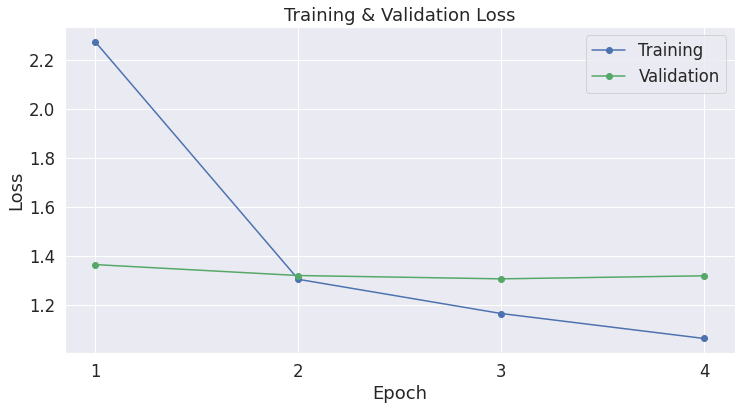

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

output_dir = '/content/drive/My Drive/breit'

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

NameError: ignored

In [ ]:
model.eval()

#prompt = "<|startoftext|>"

prompt = "David Frankenfield"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=5
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: David Frankenfield: Trump ‘Often Said, Said to Me, Things Are Good,’ but He Said Nothing ‘In the Details’


1: David Frankenfield: Trump Is ‘Going to Face a Very Tough Reelection’


2: David Frankenfield: It Is Time for Democrats to ‘Get Real and Real!’


3: David Frankenfield: Trump Is ‘a Very Disturbed Individual’ — ‘Not a Good Guy, Not Strong Enough’


4: David Frankenfield Campaign: My Family’s Business Deals Are ‘Excluding Planned Parenthood,’ ‘Cancer,’ ‘Trans Military Aid’




In [ ]:
output_dir = '/content/drive/My Drive/breit'
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [ ]:
model.save_pretrained(output_dir)

In [ ]:
model.